In [1]:
!pip install kaggle

In [2]:
from google.colab import files
files.upload()  # Chọn file kaggle.json từ máy

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"lthbac","key":"7db34f02d08ac43960b1ee5105ee823f"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d shashankrapolu/human-action-recognition-dataset

Dataset URL: https://www.kaggle.com/datasets/shashankrapolu/human-action-recognition-dataset
License(s): ODbL-1.0


In [5]:
!unzip human-action-recognition-dataset.zip

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: Structured/train/hugging/Image_9980.jpg  
  inflating: Structured/train/hugging/Image_9999.jpg  
  inflating: Structured/train/laughing/Image_10000.jpg  
  inflating: Structured/train/laughing/Image_10001.jpg  
  inflating: Structured/train/laughing/Image_10028.jpg  
  inflating: Structured/train/laughing/Image_10036.jpg  
  inflating: Structured/train/laughing/Image_10037.jpg  
  inflating: Structured/train/laughing/Image_1004.jpg  
  inflating: Structured/train/laughing/Image_1005.jpg  
  inflating: Structured/train/laughing/Image_10074.jpg  
  inflating: Structured/train/laughing/Image_10093.jpg  
  inflating: Structured/train/laughing/Image_10095.jpg  
  inflating: Structured/train/laughing/Image_10114.jpg  
  inflating: Structured/train/laughing/Image_10149.jpg  
  inflating: Structured/train/laughing/Image_10196.jpg  
  inflating: Structured/train/laughing/Image_10225.jpg  
  inflating: Structured/train/laughin

In [6]:
!ls /content
!ls /content/Structured/train

human-action-recognition-dataset.zip  kaggle.json  sample_data	Structured
calling   dancing   fighting  listening_to_music  sleeping
clapping  drinking  hugging   running		  texting
cycling   eating    laughing  sitting		  using_laptop


In [7]:
!pip install timm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 32.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [8]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import timm
import matplotlib.pyplot as plt
%matplotlib inline

# Định nghĩa 15 class hành động từ dataset
ACTION_CLASSES = [
    'calling', 'clapping', 'cycling', 'dancing', 'drinking',
    'eating', 'fighting', 'hugging', 'laughing', 'listening_to_music',
    'running', 'sitting', 'sleeping', 'texting', 'using_laptop'
]

# Tạo bộ chuyển đổi hình ảnh
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Thêm augmentation
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

class ActionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []

        # Kiểm tra thư mục gốc
        if not os.path.exists(root_dir):
            raise ValueError(f"Root directory {root_dir} does not exist.")

        # Kiểm tra từng thư mục hành động
        for label, action in enumerate(ACTION_CLASSES):
            action_dir = os.path.join(root_dir, action)
            if os.path.exists(action_dir):
                img_files = [f for f in os.listdir(action_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
                if not img_files:
                    print(f"Warning: No image files found in {action_dir}.")
                for img_name in img_files:
                    img_path = os.path.join(action_dir, img_name)
                    self.data.append((img_path, label))
            else:
                print(f"Warning: Directory {action_dir} does not exist.")

        print(f"Total images found: {len(self.data)}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = cv2.imread(img_path)
        if image is None:
            raise ValueError(f"Failed to load image: {img_path}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image)

        return image, label

# Update the root_dir to an absolute path
root_dir = "/content/Structured/train"
dataset = ActionDataset(root_dir=root_dir, transform=transform)

# Kiểm tra nếu dataset rỗng
if len(dataset) == 0:
    raise ValueError("Dataset is empty. Please check the root_dir path and ensure it contains valid data.")

# Tạo dataloader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

Total images found: 10710


In [9]:
import timm
import torch
import torch.nn as nn

# Định nghĩa mô hình Action Recognition với Vision Transformer
class ActionRecognitionModel(nn.Module):
    def __init__(self, num_classes=15):
        super(ActionRecognitionModel, self).__init__()
        # Sử dụng mô hình ViT với pretrained weights
        self.vit = timm.create_model("vit_base_patch16_224", pretrained=True)
        # Sửa đổi lớp đầu ra cho phù hợp với số class hành động
        self.vit.head = nn.Linear(self.vit.head.in_features, num_classes)

    def forward(self, x):
        return self.vit(x)

# Kiểm tra nếu có GPU, nếu không thì chạy trên CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ActionRecognitionModel(num_classes=len(ACTION_CLASSES)).to(device)

print(f"Model is using device: {device}")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Model is using device: cuda


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


100%|██████████| 268/268 [05:09<00:00,  1.16s/it]


Epoch 1/20
Train Loss: 1.0969, Train Accuracy: 0.6691
Val Loss: 0.5960, Val Accuracy: 0.8240
Test Loss: 0.5907, Test Accuracy: 0.8339
Model mới có độ chính xác tốt hơn trên validation -> Đã lưu!


100%|██████████| 268/268 [05:10<00:00,  1.16s/it]


Epoch 2/20
Train Loss: 0.4863, Train Accuracy: 0.8466
Val Loss: 0.5026, Val Accuracy: 0.8459
Test Loss: 0.4758, Test Accuracy: 0.8646
Model mới có độ chính xác tốt hơn trên validation -> Đã lưu!


100%|██████████| 268/268 [05:13<00:00,  1.17s/it]


Epoch 3/20
Train Loss: 0.3245, Train Accuracy: 0.8981
Val Loss: 0.5101, Val Accuracy: 0.8492
Test Loss: 0.5002, Test Accuracy: 0.8593
Model mới có độ chính xác tốt hơn trên validation -> Đã lưu!


100%|██████████| 268/268 [05:14<00:00,  1.17s/it]


Epoch 4/20
Train Loss: 0.2127, Train Accuracy: 0.9323
Val Loss: 0.5417, Val Accuracy: 0.8529
Test Loss: 0.5254, Test Accuracy: 0.8619
Model mới có độ chính xác tốt hơn trên validation -> Đã lưu!


100%|██████████| 268/268 [05:14<00:00,  1.17s/it]


Epoch 5/20
Train Loss: 0.1531, Train Accuracy: 0.9478
Val Loss: 0.5403, Val Accuracy: 0.8632
Test Loss: 0.5323, Test Accuracy: 0.8704
Model mới có độ chính xác tốt hơn trên validation -> Đã lưu!


100%|██████████| 268/268 [05:14<00:00,  1.17s/it]


Epoch 6/20
Train Loss: 0.1152, Train Accuracy: 0.9635
Val Loss: 0.5736, Val Accuracy: 0.8553
Test Loss: 0.5193, Test Accuracy: 0.8720


100%|██████████| 268/268 [05:11<00:00,  1.16s/it]


Epoch 7/20
Train Loss: 0.0618, Train Accuracy: 0.9838
Val Loss: 0.5443, Val Accuracy: 0.8655
Test Loss: 0.5082, Test Accuracy: 0.8762
Model mới có độ chính xác tốt hơn trên validation -> Đã lưu!


100%|██████████| 268/268 [05:16<00:00,  1.18s/it]


Epoch 8/20
Train Loss: 0.0443, Train Accuracy: 0.9879
Val Loss: 0.5517, Val Accuracy: 0.8627
Test Loss: 0.5215, Test Accuracy: 0.8778


100%|██████████| 268/268 [05:10<00:00,  1.16s/it]


Epoch 9/20
Train Loss: 0.0399, Train Accuracy: 0.9884
Val Loss: 0.5604, Val Accuracy: 0.8665
Test Loss: 0.5230, Test Accuracy: 0.8788
Model mới có độ chính xác tốt hơn trên validation -> Đã lưu!


100%|██████████| 268/268 [05:13<00:00,  1.17s/it]


Epoch 10/20
Train Loss: 0.0342, Train Accuracy: 0.9907
Val Loss: 0.5636, Val Accuracy: 0.8702
Test Loss: 0.5326, Test Accuracy: 0.8794
Model mới có độ chính xác tốt hơn trên validation -> Đã lưu!


100%|██████████| 268/268 [05:16<00:00,  1.18s/it]


Epoch 11/20
Train Loss: 0.0308, Train Accuracy: 0.9922
Val Loss: 0.5628, Val Accuracy: 0.8697
Test Loss: 0.5322, Test Accuracy: 0.8804


100%|██████████| 268/268 [05:13<00:00,  1.17s/it]


Epoch 12/20
Train Loss: 0.0284, Train Accuracy: 0.9930
Val Loss: 0.5627, Val Accuracy: 0.8716
Test Loss: 0.5318, Test Accuracy: 0.8799
Model mới có độ chính xác tốt hơn trên validation -> Đã lưu!


100%|██████████| 268/268 [05:15<00:00,  1.18s/it]


Epoch 13/20
Train Loss: 0.0281, Train Accuracy: 0.9935
Val Loss: 0.5635, Val Accuracy: 0.8711
Test Loss: 0.5334, Test Accuracy: 0.8794


100%|██████████| 268/268 [05:11<00:00,  1.16s/it]


Epoch 14/20
Train Loss: 0.0289, Train Accuracy: 0.9930
Val Loss: 0.5639, Val Accuracy: 0.8716
Test Loss: 0.5342, Test Accuracy: 0.8804


100%|██████████| 268/268 [05:12<00:00,  1.16s/it]


Epoch 15/20
Train Loss: 0.0292, Train Accuracy: 0.9924
Val Loss: 0.5641, Val Accuracy: 0.8716
Test Loss: 0.5343, Test Accuracy: 0.8799


100%|██████████| 268/268 [05:12<00:00,  1.16s/it]


Epoch 16/20
Train Loss: 0.0303, Train Accuracy: 0.9926
Val Loss: 0.5643, Val Accuracy: 0.8711
Test Loss: 0.5343, Test Accuracy: 0.8799


100%|██████████| 268/268 [05:11<00:00,  1.16s/it]


Epoch 17/20
Train Loss: 0.0306, Train Accuracy: 0.9916
Val Loss: 0.5642, Val Accuracy: 0.8711
Test Loss: 0.5344, Test Accuracy: 0.8799
Early stopping


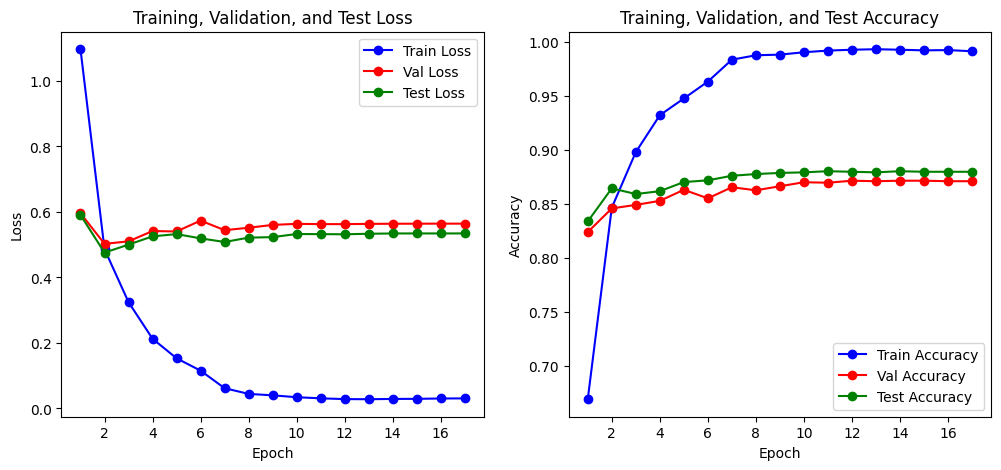

In [11]:
import os
import torch
import torch.nn as nn
import cv2
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import timm
import numpy as np
from sklearn.model_selection import train_test_split
import torch.optim as optim
import matplotlib.pyplot as plt
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define action classes
ACTION_CLASSES = [
    'calling', 'clapping', 'cycling', 'dancing', 'drinking',
    'eating', 'fighting', 'hugging', 'laughing', 'listening_to_music',
    'running', 'sitting', 'sleeping', 'texting', 'using_laptop'
]

# Define transforms
train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Define dataset class
class ActionDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []

        for label, action in enumerate(ACTION_CLASSES):
            action_dir = os.path.join(root_dir, action)
            if os.path.exists(action_dir):
                for img_name in os.listdir(action_dir):
                    img_path = os.path.join(action_dir, img_name)
                    self.data.append((img_path, label))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image)

        return image, label

# Define the model class
class ActionRecognitionModel(nn.Module):
    def __init__(self, num_classes=15):
        super(ActionRecognitionModel, self).__init__()
        self.vit = timm.create_model("vit_base_patch16_224", pretrained=True, drop_rate=0.3)
        self.vit.head = nn.Linear(self.vit.head.in_features, num_classes)

    def forward(self, x):
        return self.vit(x)

# Load datasets
train_dataset = ActionDataset(root_dir=r"/content/Structured/train", transform=train_transform)
test_dataset = ActionDataset(root_dir=r"/content/Structured/test", transform=val_test_transform)

# Split train into train/validation
train_data, val_data = train_test_split(train_dataset.data, test_size=0.2, random_state=42)
train_dataset.data = train_data
val_dataset = ActionDataset(root_dir=r"/content/Structured/train", transform=val_test_transform)
val_dataset.data = val_data

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Load model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ActionRecognitionModel(num_classes=len(ACTION_CLASSES)).to(device)

# Optimizer and loss
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

# Số epoch
num_epochs = 10

# Biến lưu trạng thái
best_val_accuracy = 0.0
train_losses = []
val_losses = []
test_losses = []
train_accuracies = []
val_accuracies = []
test_accuracies = []

# Kiểm tra nếu có checkpoint
checkpoint_path = "/content/drive/MyDrive/model_ver2.pth"
if os.path.exists(checkpoint_path):
    print("Resume từ checkpoint trước...")
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    best_val_accuracy = checkpoint.get("best_accuracy", 0.0)

# Training loop
patience = 5
counter = 0

for epoch in range(num_epochs):
    # Training phase
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in tqdm(train_dataloader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    avg_train_loss = running_loss / len(train_dataloader)
    train_accuracy = correct / total
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            val_total += labels.size(0)
            val_correct += predicted.eq(labels).sum().item()

    avg_val_loss = val_loss / len(val_dataloader)
    val_accuracy = val_correct / val_total
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_accuracy)

    # Test phase
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for images, labels in test_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()

    avg_test_loss = test_loss / len(test_dataloader)
    test_accuracy = test_correct / test_total
    test_losses.append(avg_test_loss)
    test_accuracies.append(test_accuracy)

    # In kết quả
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
    print(f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")
    print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # Scheduler step
    scheduler.step(avg_val_loss)

    # Lưu model tốt nhất dựa trên validation accuracy
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        counter = 0
        torch.save({
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "best_accuracy": best_val_accuracy,
        }, checkpoint_path)
        print("Model mới có độ chính xác tốt hơn trên validation -> Đã lưu!")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping")
            break

# Vẽ biểu đồ so sánh Loss và Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, marker="o", linestyle="-", color="b", label="Train Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, marker="o", linestyle="-", color="r", label="Val Loss")
plt.plot(range(1, len(test_losses) + 1), test_losses, marker="o", linestyle="-", color="g", label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, marker="o", linestyle="-", color="b", label="Train Accuracy")
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, marker="o", linestyle="-", color="r", label="Val Accuracy")
plt.plot(range(1, len(test_accuracies) + 1), test_accuracies, marker="o", linestyle="-", color="g", label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training, Validation, and Test Accuracy")
plt.legend()

plt.show()